# Análisis de sentimiento según revisiones de películas

__Autor: Alejandro Notario__

En este notebook se desarrolla el entrenamiento de 3 modelos diferentes para la predicción de rating de películas según los comentarios reditrados en el sitio web _Rotten tomatoes_
En el dataset de entrenamiento se encuentran

__Flujo de trabajo:__

- Exploración de datos
- Procesamiento de texto
- Entrenamiento y aplicación de modelos predictivos
- Obtención del mejor resultado según la precisión obtenida

__Librerías__

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#NLTK 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Sklearn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anotario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importación de datos

In [2]:
train_data = pd.read_csv('./train.tsv',sep='\t')
test_data = pd.read_csv('./test.tsv',sep='\t')

### Exploración de datos

Breve exploración para conocer dimensiones y distribución


In [3]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print("Dimensiones de dataframes:")
print("Train: " ,train_data.shape[0])
print("Test", test_data.shape[0])

Dimensiones de dataframes:
Train:  156060
Test 66292


In [5]:
print("Distribución de valoraciones: ")
print(train_data.Sentiment.value_counts())

Distribución de valoraciones: 
2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


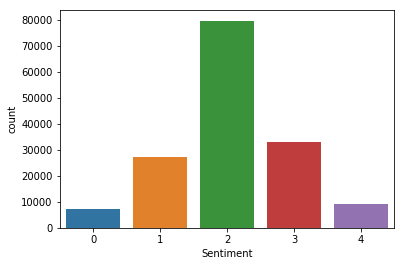

In [6]:
sns.countplot(train_data['Sentiment'])

### Procesamiento de texto

In [7]:
def text_process(phrase): 
    
    """
    Esta función procesa el texto
    eliminando puntuación, tokenizando,
    y lematizando
    """  
    phrase = re.sub('[^a-zA-Z]|[0-9]', ' ',phrase)
    phrase = word_tokenize(phrase.lower())
    lemmatizer = WordNetLemmatizer()
    phrase = [lemmatizer.lemmatize(w) for w in phrase if not w in set(stopwords.words('english'))]
    return (' '.join(phrase))

In [8]:
%%time
train_data['clean_phrases'] = train_data['Phrase'].apply(text_process)
test_data['clean_phrases'] = test_data['Phrase'].apply(text_process)

CPU times: user 2min 11s, sys: 9.11 s, total: 2min 20s
Wall time: 2min 20s


In [9]:
test_data.head()

,PhraseId,SentenceId,Phrase,clean_phrases
0,156061,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing mostly routine effort
1,156062,8545,An intermittently pleasing but mostly routine ...,intermittently pleasing mostly routine effort
2,156063,8545,An,
3,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing mostly routine


### Vectorización

In [10]:
cv = CountVectorizer(max_features = 1500, min_df=10)
x__train = cv.fit_transform(train_data.clean_phrases).toarray()
x__test= cv.fit_transform(test_data.clean_phrases).toarray()
y = train_data.Sentiment.values

### Preparación de los datos para el entrenamiento

Se divide del dataset de entrenamiento en dataset para entrenar el modelo, con el 70% y un 30% como dataset de test para estudiar la precisión 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x__train, y, test_size = 0.30,random_state = 0)

### Aplicación de modelos predictivos

__Regresión Logística__

In [12]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
pred_logReg = logreg.predict(x__test) #predicciones sobre el dataset de test
print('Precisión del clasificador por Regresión Logística: {:.2f}'.format(logreg.score(X_test, y_test)))
global confusion_matrix #this is to avoid unbound error
cfm = confusion_matrix(y_test, y_pred)
print("===============")
print("matriz de confusión")
print(cfm)
print("===============")
print("informe del modelo")
print(classification_report(y_test, y_pred))

Precisión del clasificador por Regresión Logística: 0.59
matriz de confusión
[[  333   695  1041   116     8]
 [  242  1757  5579   526    35]
 [   71   866 21801  1199    87]
 [   26   318  5824  3157   370]
 [    7    72   923  1210   555]]
informe del modelo
              precision    recall  f1-score   support

           0       0.49      0.15      0.23      2193
           1       0.47      0.22      0.30      8139
           2       0.62      0.91      0.74     24024
           3       0.51      0.33      0.40      9695
           4       0.53      0.20      0.29      2767

   micro avg       0.59      0.59      0.59     46818
   macro avg       0.52      0.36      0.39     46818
weighted avg       0.56      0.59      0.54     46818



__Naive Bayes__

In [13]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
pred_naiveBayes = naive_bayes.predict(x__test)
print('Precisión del clasificador por Naive Bayes: {:.2f}'.format(naive_bayes.score(X_test, y_test)))
global confusion_matrix #this is to avoid unbound error
cfm = confusion_matrix(y_test, y_pred)
print("===============")
print("matriz de confusión")
print(cfm)
print("===============")
print("informe del modelo")
print(classification_report(y_test, y_pred))

Precisión del clasificador por Naive Bayes: 0.58
matriz de confusión
[[  297   590  1206    92     8]
 [  199  1511  5998   398    33]
 [   63   739 22035  1132    55]
 [   13   240  6089  3028   325]
 [    3    51  1071  1151   491]]
informe del modelo
              precision    recall  f1-score   support

           0       0.52      0.14      0.21      2193
           1       0.48      0.19      0.27      8139
           2       0.61      0.92      0.73     24024
           3       0.52      0.31      0.39      9695
           4       0.54      0.18      0.27      2767

   micro avg       0.58      0.58      0.58     46818
   macro avg       0.53      0.35      0.37     46818
weighted avg       0.56      0.58      0.53     46818



__SVM__

In [14]:
svm=SGDClassifier()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
pred_svm = svm.predict(x__test)
print('Precisión del clasificador por Máquina de Vectores de Soporte: {:.2f}'.format(svm.score(X_test, y_test)))
global confusion_matrix #this is to avoid unbound error
cfm = confusion_matrix(y_test, y_pred)
print("===============")
print("matriz de confusión")
print(cfm)
print("===============")
print("informe del modelo")
print(classification_report(y_test, y_pred))

Precisión del clasificador por Máquina de Vectores de Soporte: 0.57
matriz de confusión
[[  380   399  1224   176    14]
 [  385   929  6164   607    54]
 [  132   418 22249  1137    88]
 [   70   165  6236  2930   294]
 [   25    37  1061  1220   424]]
informe del modelo
              precision    recall  f1-score   support

           0       0.38      0.17      0.24      2193
           1       0.48      0.11      0.18      8139
           2       0.60      0.93      0.73     24024
           3       0.48      0.30      0.37      9695
           4       0.49      0.15      0.23      2767

   micro avg       0.57      0.57      0.57     46818
   macro avg       0.49      0.33      0.35     46818
weighted avg       0.54      0.57      0.51     46818



### Guardar el mejor modelo de los 3

In [15]:
dump(logreg, 'logregmodel.joblib')

['logregmodel.joblib']

### Cargar modelo de regresión Logística

In [16]:
#aplicación del modelo sobre el dataset de test
pipe=load('logregmodel.joblib')
pred = pd.Series(pipe.predict(x__test))

In [17]:
test_data['Sentiment']=pred

In [18]:
resultados=test_data[['PhraseId','Sentiment']].copy()

__Distribución de sentimientos__

In [19]:
resultados.Sentiment.value_counts()

2    49093
3     9269
1     6032
4     1142
0      756
Name: Sentiment, dtype: int64

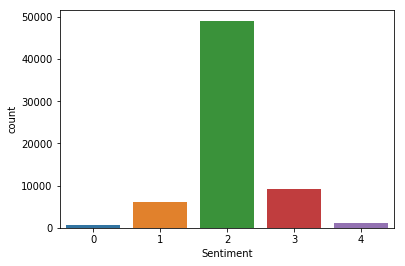

In [20]:
sns.countplot(resultados['Sentiment'])

### Exportar a .csv

In [21]:
resultados.to_csv('submission.csv')